In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import csv_loader as loader
import scipy.stats as stats


terrorism = loader.get_csv_file('terrorism')
prime_ministers = loader.get_csv_file('prime_ministers')
pd.set_option('display.max_columns', None)

#Question - does the government wing affect the amount of terror attacks 

C:\Users\yvesk\AppData\Local\Temp\ipykernel_6068\2199435683.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
c:\Users\yvesk\Desktop\analyst_project\Project\csv_loader.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['approxdate'] = pd.to_datetime(dict(year=dataframe['iyear'], month=dataframe['imonth'], day=dataframe['iday']))
c:\Users\yvesk\D

In [2]:
#fixting datetimes in prime_ministers
prime_ministers['time_started'] = pd.to_datetime(prime_ministers['time_started'], format='%d/%m/%Y')
prime_ministers['time_ended'] = pd.to_datetime(prime_ministers['time_ended'], format='%d/%m/%Y')

#merging prime ministers and terrorism databases
countries = ['West Bank and Gaza Strip', 'Israel']
israeli_terror = terrorism[(terrorism['country_txt'].isin(countries)) & (terrorism['provstate'] != 'Gaza Strip')].copy()

for attack in israeli_terror.index.to_list():
    for prime_minister in range(len(prime_ministers)):
        if prime_ministers.loc[prime_minister, 'time_started'] <= israeli_terror.loc[attack, 'approxdate'] <= prime_ministers.loc[prime_minister, 'time_ended']: 
            israeli_terror.loc[attack, 'prime_minister'] = prime_ministers.loc[prime_minister, 'prime_minister']
            israeli_terror.loc[attack,'prime_minister_wing'] = prime_ministers.loc[prime_minister, 'wing']
            break

C:\Users\yvesk\AppData\Local\Temp\ipykernel_6068\1656014078.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'left' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  avg_terror_by_wing.at[0, 'wing'], avg_terror_by_wing.at[1, 'wing'] = 'left', 'right'


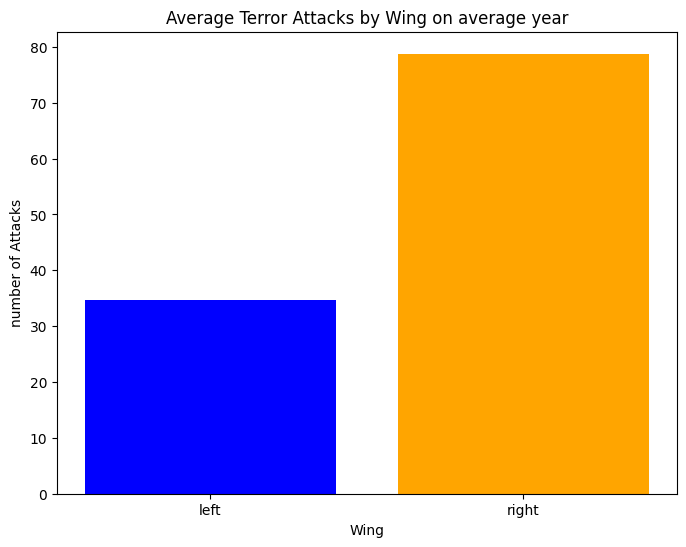

    wing  avg_terrorattacks_in_year
0   left                      34.73
1  right                      78.77


In [3]:
#calculating avg terror attacks by wing
terror_by_year = israeli_terror.groupby(['prime_minister','prime_minister_wing', 'iyear']).size().sort_values(ascending=False).reset_index(name='count')
years_in_charge = terror_by_year.groupby('prime_minister_wing').size().reset_index(name='count')
terror_by_wing = israeli_terror.groupby('prime_minister_wing').size().reset_index(name='count')
terror_by_wing_prop_year = round(terror_by_wing['count']/years_in_charge['count'],2)
avg_terror_by_wing = terror_by_wing_prop_year.reset_index()


#adjusting it abit
avg_terror_by_wing = avg_terror_by_wing.rename(columns={'index': 'wing','count': 'avg_terrorattacks_in_year'})
avg_terror_by_wing.at[0, 'wing'], avg_terror_by_wing.at[1, 'wing'] = 'left', 'right'

#graph
plt.figure(figsize=(8, 6))
plt.bar(avg_terror_by_wing['wing'], avg_terror_by_wing['avg_terrorattacks_in_year'], color=['blue', 'orange'])
plt.title('Average Terror Attacks by Wing on average year')
plt.xlabel('Wing')
plt.ylabel('number of Attacks')
plt.show()

print(avg_terror_by_wing)

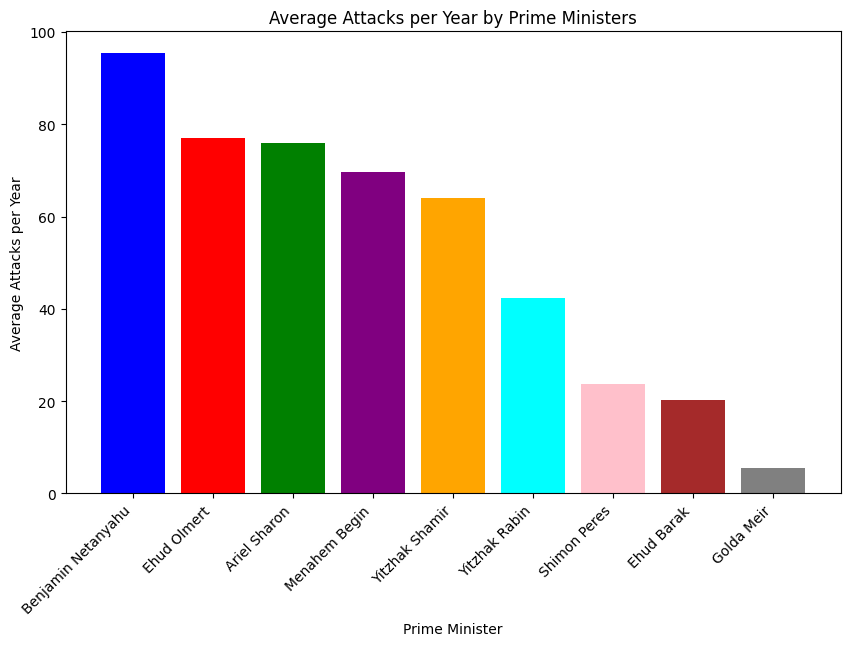

In [4]:
#creating a df with prime ministers, years in charge and terror attacks when they were prime ministers
years_in_charge_pm = terror_by_year.groupby(['prime_minister','prime_minister_wing']).size().reset_index(name='count')
terror_in_charge_pm = israeli_terror.groupby(['prime_minister','prime_minister_wing']).size().reset_index(name='count')
pm_conclusion = pd.merge(years_in_charge_pm, terror_in_charge_pm, on='prime_minister', how='inner')
pm_conclusion = pm_conclusion.rename(columns={'count_x': 'years_in_charge', 'count_y': 'terror_count','prime_minister_wing_x':'prime_minister_wing'})
pm_conclusion = pm_conclusion.drop('prime_minister_wing_y', axis=1)
pm_conclusion['avg attacks per year'] = round(pm_conclusion['terror_count']/pm_conclusion['years_in_charge'],2)
pm_conclusion = pm_conclusion.sort_values(by='avg attacks per year', ascending=False)

#graph
plt.figure(figsize=(10, 6))
plt.bar(pm_conclusion['prime_minister'], pm_conclusion['avg attacks per year'], color=['blue', 'red', 'green', 'purple', 'orange', 'cyan', 'pink', 'brown', 'grey'])
plt.xlabel('Prime Minister')
plt.ylabel('Average Attacks per Year')
plt.title('Average Attacks per Year by Prime Ministers')
plt.xticks(rotation=45, ha='right')  
plt.show()






#idea - you press the wing and show the prime ministers chart of each wing

In [5]:
data_right = pm_conclusion[pm_conclusion['prime_minister_wing'] == 'Right']
data_left = pm_conclusion[pm_conclusion['prime_minister_wing'] == 'Left']

t_statistic, p_value = stats.ttest_ind(data_left['avg attacks per year'], data_right['avg attacks per year'])

print(f'T-statistic: {t_statistic}')
print(f'P-value: {p_value}')

alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis")

T-statistic: -2.7941621076809615
P-value: 0.026747767012714307
Reject the null hypothesis
